In [16]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import psi
import collections
import json
from scipy import sparse
import sklearn.cluster
import sklearn.decomposition
# lda package for gibbs sampler
import lda

import sys
import os.path
sys.path.append('util')

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

import numpy as np
sys.path.append('OVI')
import lda_ovi
import time

Compiling with /usr/local/bin/clang-omp


# Features Extraction

We use here three different methods to extract features from the reviews, ie to convert the document term matrix into a document features latent matrix:
* online variationnal inference LDA (coded from scratch)
* Gibbs sampling LDA (coded from scratch)
* Non-negative Matrix Factorisation (from scikit)

### Loading the data

In [2]:
# Vocabulary
lv_vocab10 = np.load('temp/Lasvegas_data/lv_vocab10.npy')

In [3]:
# Loading the dtm
dtm_train = np.load('../Lasvegas/dtm_lv_train.npy')
dtm_test = np.load('../Lasvegas/dtm_lv_test.npy')
dtm = dtm_test + dtm_train

In [26]:
# Global parameters
num_topics = 54

### Online variationnal inference

In [27]:
%%time
tau = 512
kappa = 0.7
batchsize = 40

model_ovi = lda_ovi.LDA(num_topics=num_topics, num_threads=8)
model_ovi.fit(dtm, batchsize, tau, kappa)

CPU times: user 2min, sys: 2.8 s, total: 2min 3s
Wall time: 51.2 s


In [11]:
# Cross validation on the number of topics
K = range(30, 70, 3)
model_ovi = lda_ovi.LDA(num_topics=num_topics, num_threads=8)
perplexity_dict = {}
for k in K:
    model_ovi.set_topics(k)
    %time model_ovi.fit(dtm_train, batchsize, tau, kappa)
    perplexity_dict[k] = model_ovi.perplexity(dtm_test,batchsize,tau,kappa)

CPU times: user 30.5 s, sys: 932 ms, total: 31.5 s
Wall time: 13.7 s
CPU times: user 34.9 s, sys: 859 ms, total: 35.8 s
Wall time: 15.4 s
CPU times: user 43.4 s, sys: 1.09 s, total: 44.5 s
Wall time: 20.8 s
CPU times: user 45.6 s, sys: 1.2 s, total: 46.8 s
Wall time: 20.5 s
CPU times: user 52.8 s, sys: 1.39 s, total: 54.2 s
Wall time: 24.4 s
CPU times: user 57.2 s, sys: 1.42 s, total: 58.6 s
Wall time: 25.9 s
CPU times: user 1min 3s, sys: 1.51 s, total: 1min 5s
Wall time: 28.4 s
CPU times: user 1min 12s, sys: 1.75 s, total: 1min 14s
Wall time: 32.3 s
CPU times: user 1min 17s, sys: 1.82 s, total: 1min 19s
Wall time: 34.1 s
CPU times: user 1min 27s, sys: 2.14 s, total: 1min 29s
Wall time: 38.5 s
CPU times: user 1min 53s, sys: 2.38 s, total: 1min 56s
Wall time: 50.1 s
CPU times: user 2min, sys: 2.43 s, total: 2min 2s
Wall time: 51.6 s
CPU times: user 2min 8s, sys: 2.58 s, total: 2min 10s
Wall time: 55.1 s
CPU times: user 2min 19s, sys: 2.83 s, total: 2min 22s
Wall time: 1min 2s


In [24]:
perp_val = sorted(perplexity_dict.items(), key=lambda x: x[0])
perp_val

[(30, -0.86500487888369282),
 (33, -0.86256166352652996),
 (36, -0.80447093946197168),
 (39, -0.80466106414470784),
 (42, -0.80987776140965051),
 (45, -0.75569058556394497),
 (48, -0.75880192806942381),
 (51, -0.71814601711573811),
 (54, -0.71552191289501321),
 (57, -0.85865804786348465),
 (60, -1.0727739734523476),
 (63, -1.0737854717759028),
 (66, -1.1582356662244455),
 (69, -1.1584515121693173)]

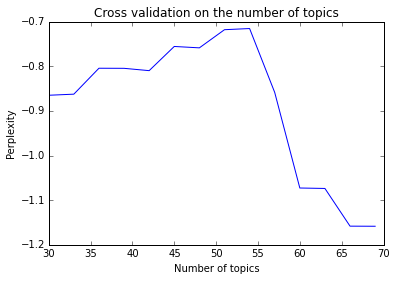

In [25]:
plt.plot([p[0] for p in perp_val], [p[1] for p in perp_val])
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')

plt.title('Cross validation on the number of topics')
plt.show()

In [28]:
np.save('temp/reviews_features/ovi_54_gamma', model_ovi.gamma)
np.save('temp/reviews_features/ovi_54_topics', model_ovi.topics)

### Gibbs sampling


In [34]:
%%time
iterations = 1500

model_gs = lda.LDA(n_topics=num_topics, n_iter=iterations, random_state=1)
model_gs.fit(dtm)

CPU times: user 1h 7min 23s, sys: 17.6 s, total: 1h 7min 41s
Wall time: 1h 8min 9s


In [39]:
np.save('temp/reviews_features/lda_gs_54_gamma', model_gs.doc_topic_)
np.save('temp/reviews_features/lda_gs_54_topics', model_gs.components_)

### NMF


In [29]:
%%time

model_nmf = sklearn.decomposition.NMF(num_topics,max_iter=2000)
model_nmf.fit(dtm)

CPU times: user 7min 57s, sys: 1min 55s, total: 9min 52s
Wall time: 6min 41s


In [31]:
gamma_nmf = model_nmf.transform(dtm)

In [38]:
np.save('temp/reviews_features/nmf_54_gamma', gamma_nmf)
np.save('temp/reviews_features/nmf_54_topics', model_nmf.components_)